In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from datetime import datetime
from netCDF4 import Dataset
# from skimage import transform
from plot_picture_function import set_map_ticks,add_Chinese_provinces
from datetime import timedelta
import cartopy.crs as ccrs
import gc

In [4]:
gc.enable()

In [5]:
dataERA5 = xr.open_dataset('E:/ZiYuanPingGu/ERA5/contain_cloudcover/202001.nc')
dataERA5

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 161, time: 744)
Coordinates:
  * longitude  (longitude) float32 80.0 80.25 80.5 80.75 ... 134.5 134.8 135.0
  * latitude   (latitude) float32 55.0 54.75 54.5 54.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:00:00
Data variables:
    tcc        (time, latitude, longitude) float32 ...
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-16 00:38:35 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [6]:
#  15N-55N  80E-135E
lon = dataERA5.longitude#经度
lat = dataERA5.latitude#维度
x2, y2 = np.meshgrid(lon, lat)#转化为坐标数据格式

In [7]:
st = '2020-01-01_00:00'
et = '2020-01-31_23:00'
d1 = datetime.strptime(st,'%Y-%m-%d_%H:%M')#type:str--->datetime
d2 = datetime.strptime(et,'%Y-%m-%d_%H:%M')

step = timedelta(minutes = 60)#设置datetime.timedelta类型的步进
seconds = (d2-d1).total_seconds()#转换成分钟   其中d2-d1为datetime.timedelta类型  timedelta只能储存days，seconds，microseconds

files = []
for i in range(0, int(seconds)+1, int(step.total_seconds())):
    if (d1 + timedelta(seconds=i)).hour in [0, 6, 12, 18]:
        files.append(d1 + timedelta(seconds=i))

In [8]:
datetime.strftime(files[0],'%Y-%m-%d_%H-%M')

'2020-01-01_00-00'

In [9]:
filesname = [date.strftime('%Y%m/%d/%H/') +
         f'NC_H08_{date.strftime("%Y%m%d_%H%M")}_L2CLP010_FLDK.02401_02401.nc'
         for date in files]

In [10]:
filesname

['202001/01/00/NC_H08_20200101_0000_L2CLP010_FLDK.02401_02401.nc',
 '202001/01/06/NC_H08_20200101_0600_L2CLP010_FLDK.02401_02401.nc',
 '202001/01/12/NC_H08_20200101_1200_L2CLP010_FLDK.02401_02401.nc',
 '202001/01/18/NC_H08_20200101_1800_L2CLP010_FLDK.02401_02401.nc',
 '202001/02/00/NC_H08_20200102_0000_L2CLP010_FLDK.02401_02401.nc',
 '202001/02/06/NC_H08_20200102_0600_L2CLP010_FLDK.02401_02401.nc',
 '202001/02/12/NC_H08_20200102_1200_L2CLP010_FLDK.02401_02401.nc',
 '202001/02/18/NC_H08_20200102_1800_L2CLP010_FLDK.02401_02401.nc',
 '202001/03/00/NC_H08_20200103_0000_L2CLP010_FLDK.02401_02401.nc',
 '202001/03/06/NC_H08_20200103_0600_L2CLP010_FLDK.02401_02401.nc',
 '202001/03/12/NC_H08_20200103_1200_L2CLP010_FLDK.02401_02401.nc',
 '202001/03/18/NC_H08_20200103_1800_L2CLP010_FLDK.02401_02401.nc',
 '202001/04/00/NC_H08_20200104_0000_L2CLP010_FLDK.02401_02401.nc',
 '202001/04/06/NC_H08_20200104_0600_L2CLP010_FLDK.02401_02401.nc',
 '202001/04/12/NC_H08_20200104_1200_L2CLP010_FLDK.02401_02401.

In [11]:
ERA5_data = np.zeros([dataERA5.dims['time'], 3, 221, 241])
JRA55_data = np.zeros([dataERA5.dims['time'], 3, 45, 49])
MERRA2_data = np.zeros([dataERA5.dims['time'], 3, 111, 121])

In [12]:
def Get_H8lonlatindex(inputlon, inputlat):#获取80-135E，55-15N范围内对应的索引

    outputlon = round((inputlon - 80)/0.05)
    outputlat = round(-(inputlat - 60)/0.05)
    return outputlon, outputlat

def Get_delta_array(num):

    dim_array = np.array([np.arange(0, 2*num+1) for i in range(2*num+1)])
    dimT_array = dim_array.T
    alpha_array = abs(dim_array-(num)) + abs(dimT_array-(num))
    max_dist = np.max(alpha_array)
    total_num = np.sum(max_dist - alpha_array)
    delta_array = (max_dist - alpha_array) ** 2

    return delta_array

def transformH8(data1, data2, resolution1, resolution2):#data1是低分辨，data2高分辨数据，避免单独处理边缘格点

    num = round((resolution1/resolution2 - 1) / 2)#匹配方框区域格点半边长
    trans_array = np.ones(data1.shape)*(-1)
    
    treshold_u = round((resolution1/resolution2 - 1)**2*0.8)#一般情况下的阈值个数（80%的条件）
    
    delta_array = Get_delta_array(num)
                
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            lon = 80 + j*resolution1
            lat = 55 - i*resolution1
#             print('lon:{0}, lat:{1}'.format(lon, lat))
            H8_lonindex, H8_latindex = Get_H8lonlatindex(lon, lat)
            if j == 0:
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex:H8_lonindex+num+1]
                datanum = len(temp_array.flatten())
                treshold = round(datanum * 0.8)
                if np.sum(~np.isnan(temp_array)) >= treshold:
                    trans_array[i, j] = np.mean(temp_array[~np.isnan(temp_array)])

            else:         
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex-num:H8_lonindex+num+1] * delta_array
                datanum = len(temp_array.flatten())
                if np.sum(~np.isnan(temp_array)) >= treshold_u:
                    delta_sum = np.sum(delta_array[~np.isnan(temp_array)])
                    trans_array[i, j] = np.sum(temp_array[~np.isnan(temp_array)]) / delta_sum
                    

    return trans_array

def transformCLoudH8(data1, data2, resolution1, resolution2):#data1是局部数据，data2为全域数据，避免单独处理边缘格点
    num = round((resolution1/resolution2 - 1) / 2)#匹配方框区域格点半边长
    trans_array = np.zeros(data1.shape)
    
    treshold_u = round((resolution1/resolution2 - 1)**2*0.8)#一般情况下的阈值个数（80%的条件）
    
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            lon = 80 + j*resolution1
            lat = 55 - i*resolution1
#             print('lon:{0}, lat:{1}'.format(lon, lat))
            H8_lonindex, H8_latindex = Get_H8lonlatindex(lon, lat)
            if j == 0:
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex:H8_lonindex+num+1]
                datanum = len(temp_array.flatten())
                treshold = round(datanum * 0.8)
                if np.sum(temp_array > 0.8) >= treshold:
                    trans_array[i, j] = 1

            else:
                temp_array = data2[H8_latindex-num:H8_latindex+num+1, H8_lonindex-num:H8_lonindex+num+1]
                datanum = len(temp_array.flatten())
                if np.sum(temp_array > 0.8) >= treshold_u:
                    trans_array[i, j] = 1
    return trans_array

In [27]:
def Get_Bias(H8filesname, fileindex):
    datakuihua = xr.open_dataset('F:/ZiYuanPingGu/hiwimari8_data/hiwamari/2020/'+H8filesname)

    lon_w = 0#索引，下同, 80E
    lon_e = 1200 #140E
    lat_n = 100 # 55N
    lat_s = 1200 # 0N/S
    

    binary_repr_v = np.vectorize(np.binary_repr)
    
    def slice_str(str1, st, ed):
        return str1[st:ed]

    binary_repr_v = np.vectorize(np.binary_repr)
    slice_str_v = np.vectorize(slice_str)
    qa = datakuihua.QA
    qa_int = qa.data
    qa_int = qa_int.astype(np.int)
    qa_bin = binary_repr_v(qa_int, 16)
    
    #云水、云冰检测
    qa65 = slice_str_v(qa_bin, 9, 11)
    #云检测
    qasc = slice_str_v(qa_bin, -5, -3)
    qa65 = qa65.reshape(2401,2401)
    qasc = qasc.reshape(2401,2401)
    qa_wc = np.zeros([2401, 2401])*np.nan#水云数据矩阵初始化
    qa_ic = np.zeros([2401, 2401])*np.nan
    qa_cloud = np.zeros([2401, 2401])
    qa_wc[qa65 == '01'] = 1  #监测水云
    qa_ic[qa65 == '11'] = 1  #监测冰云
    qa_cloud[qasc == '11'] = 1 #监测云像素
    print('clear ?:', np.all(qa_cloud == 0))

    #匹配空间分辨率
    ct = datakuihua.CLOT.values
    cr = datakuihua.CLER_23.values
    clt = datakuihua.CLTT.values
    #去除无效值
    cr[cr < -326] = np.nan
    ct[ct < -326] = np.nan
    
    # print('cr shape:', cr.shape)
    #计算lwp
    H8lwp = ct * cr * 5/9 * 0.001
    lwp_qa = qa_wc * H8lwp #去除非云像素点
    #筛选水云
    lwp_qa[clt < 268] = np.nan
    lwparray_asERA5 = transformH8(np.zeros([221,241]), lwp_qa, 0.25, 0.05)
    lwparray_asJRA55 = transformH8(np.zeros([45,49]), lwp_qa, 1.25, 0.05)
    lwparray_asMERRA2 = transformH8(np.zeros([111,121]), lwp_qa, 0.5, 0.05)
    #计算iwp
    H8iwp = (ct**(1/0.84))/0.065 * 0.001
    iwp_qa = qa_ic * H8iwp #去除非云像素点
    print(
        "NAN check:", np.nanmax(iwp_qa), np.nanmax(lwp_qa)
        )
    # iwp_qa[clt < 268] = np.nan     
    iwparray_asERA5 = transformH8(np.zeros([221,241]), iwp_qa, 0.25, 0.05)
    iwparray_asJRA55 = transformH8(np.zeros([45,49]), iwp_qa, 1.25, 0.05)
    iwparray_asMERRA2 = transformH8(np.zeros([111,121]), iwp_qa, 0.5, 0.05)
    
    #处理cloud_sc 标签
    scarray_asERA5 = transformCLoudH8(np.zeros([221,241]), qa_cloud, 0.25, 0.05)
    scarray_asJRA55 = transformCLoudH8(np.zeros([45,49]), qa_cloud, 1.25, 0.05)
    scarray_asMERRA2 = transformCLoudH8(np.zeros([111,121]), qa_cloud, 0.5, 0.05)
    
    H8_bar = np.array([lwp_qa, iwp_qa, qa_cloud])
    ERA5_bar = np.array([lwparray_asERA5, iwparray_asERA5, scarray_asERA5])
    JRA55_bar = np.array([lwparray_asJRA55, iwparray_asJRA55, scarray_asJRA55])
    MERRA2_bar = np.array([lwparray_asMERRA2, iwparray_asMERRA2, scarray_asMERRA2])
    return H8_bar, ERA5_bar, JRA55_bar, MERRA2_bar
    

In [28]:
for fileindex in range(0, len(filesname)):
    try:
        H8_bar, ERA5_bar, JRA55_bar, MERRA2_bar = Get_Bias(filesname[fileindex], fileindex)
        ERA5_data[fileindex,:,:,:] = ERA5_bar
        JRA55_data[fileindex,:,:,:] = JRA55_bar
        MERRA2_data[fileindex,:,:,:] = MERRA2_bar
    except:
        print("Process ******error*******:", fileindex)#利用一些输出来查看代码的出错点。

        continue

    print("Process:", fileindex)

C:\Users\dell\AppData\Local\Temp\ipykernel_40464\564153767.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qa_int = qa_int.astype(np.int)


clear ?: False
NAN check: 5.993375301361084 2.9200000762939453
Process: 0
clear ?: False
NAN check: 5.993375301361084 2.9444057941436768
Process: 1
clear ?: False
NAN check: 5.993375301361084 0.8450000286102295
Process: 2
clear ?: False
NAN check: 5.993375301361084 3.4216668605804443
Process: 3
clear ?: False
NAN check: 5.993375301361084 3.4438891410827637
Process: 4
clear ?: False
NAN check: 5.993375301361084 3.4422223567962646
Process: 5
clear ?: False
NAN check: 5.993375301361084 1.0722222328186035
Process: 6
clear ?: False
NAN check: 5.993375301361084 1.527777910232544
Process: 7
clear ?: False
NAN check: 5.993375301361084 3.2911112308502197
Process: 8
clear ?: False
NAN check: 5.993375301361084 3.097778081893921
Process: 9
clear ?: False
NAN check: 5.993375301361084 0.4911111295223236
Process: 10
clear ?: False
NAN check: 5.993375301361084 1.1911109685897827
Process: 11
clear ?: False
NAN check: 5.993375301361084 3.3947436809539795
Process: 12
clear ?: False
NAN check: 5.993375301

In [33]:
[f'{i:02}' for i in range(2, 13, 1)]

['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [29]:
ds = xr.Dataset({'ERA5_data': (('time','phase','lat1','lon1'), ERA5_data),
                 'JRA55_data': (('time','phase','lat2','lon2'), JRA55_data),
                 'MERRA2_data': (('time','phase','lat3','lon3'), MERRA2_data)
                })
# ds.attrs['time scale'] = st+'-->'+et
ds.to_netcdf('F:/ZiYuanPingGu/GRL_data/202001.nc')#储存数据集

In [15]:
def plot_pic(dataset1, dataset2, dataset3, dataset4):#画图
    extent = [80, 135, 15, 55]
    levels = np.linspace(0, 0.6, 11)
    proj = ccrs.PlateCarree()#选择投影方式，平面投影
    
    fig = plt.figure(figsize=(8,6.5), dpi=500)
    ax1 = fig.add_subplot(221, projection=proj)#创建一个轴，或者是说主体
    ax1.set_title('(a)H8', fontsize=12, loc='left')
    
    x_ori = np.linspace(80,140,1201)
    y_ori = np.linspace(55,0,1101)
    im1 = ax1.contourf(x_ori, y_ori, dataset1, levels=levels, cmap='rainbow', extend='max')
    add_Chinese_provinces(ax1, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    set_map_ticks(ax1, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax1.set_extent(extent, crs=proj)

    ax2 = fig.add_subplot(222, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax2, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax2.set_title('(b)ERA5', fontsize=12, loc='left')
    # ERA5
    X_cut = np.linspace(80,140,241)
    Y_cut = np.linspace(55,0,221)
    im2 = ax2.contourf(X_cut, Y_cut, dataset2, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax2, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax2.set_extent(extent, crs=proj)
    #设置colorbar的位置
    cax2 = fig.add_axes([ax2.get_position().x1 + 0.01, ax2.get_position().y0, 0.02, ax2.get_position().height])
    plt.colorbar(im2, cax=cax2, label='kg·m$^-$$^2$')
    
    ax3 = fig.add_subplot(223, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax3, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick
    ax3.set_title('(c)JRA55', fontsize=12, loc='left')
    # JRA-55
    X_JRA55 = np.linspace(80,140,49)
    Y_JRA55 = np.linspace(55,0,45)
    im3 = ax3.contourf(X_JRA55, Y_JRA55, dataset3, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax3, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax3.set_extent(extent, crs=proj)
    
    ax4 = fig.add_subplot(224, projection=proj)#创建一个轴，或者是说主体
    # 设置经纬度刻度.
    set_map_ticks(ax4, dx=10, dy=10, nx=1, ny=1, labelsize='small')#自定义函数set_map_tick

    ax4.set_title('(d)MERRA2', fontsize=12, loc='left')
    # MERRA-2
    X_MERRA2 = np.linspace(80,145,121)
    Y_MERRA2 = np.linspace(55,0,111)
    im4 = ax4.contourf(X_MERRA2, Y_MERRA2, dataset4, levels=levels, cmap = 'rainbow', extend='max')
    add_Chinese_provinces(ax4, lw=0.5, ec='gray', fc='none')#后两个参数是设置eagecolor,facecolor,linewigth线宽
    ax4.set_extent(extent, crs=proj)
    #设置colorbar的位置
    cax4 = fig.add_axes([ax4.get_position().x1 + 0.01, ax4.get_position().y0, 0.02, ax4.get_position().height])
#     cax5 = fig.add_axes([ax4.get_position().x1 + 0.03, ax4.get_position().y1+0.01, 0.04, 0.03])
#     cax5.text(0,0.1,'kg·m$^-$$^2$')
#     cax5.spines['top'].set_visible(False)
#     cax5.spines['bottom'].set_visible(False)
#     cax5.spines['left'].set_visible(False)
#     cax5.spines['right'].set_visible(False)
#     cax5.set_xticks([])
#     cax5.set_yticks([])
    plt.colorbar(im4, cax=cax4, label='kg·m$^-$$^2$')

In [17]:
np.isnan(lwp_CHN_ori).all()

True

In [ ]:
lwp_CHN_ori.shape, ERA5_CHN_cw.shape, JRA55_CHN_cw.shape, MERRA2_CHN_cw.shape

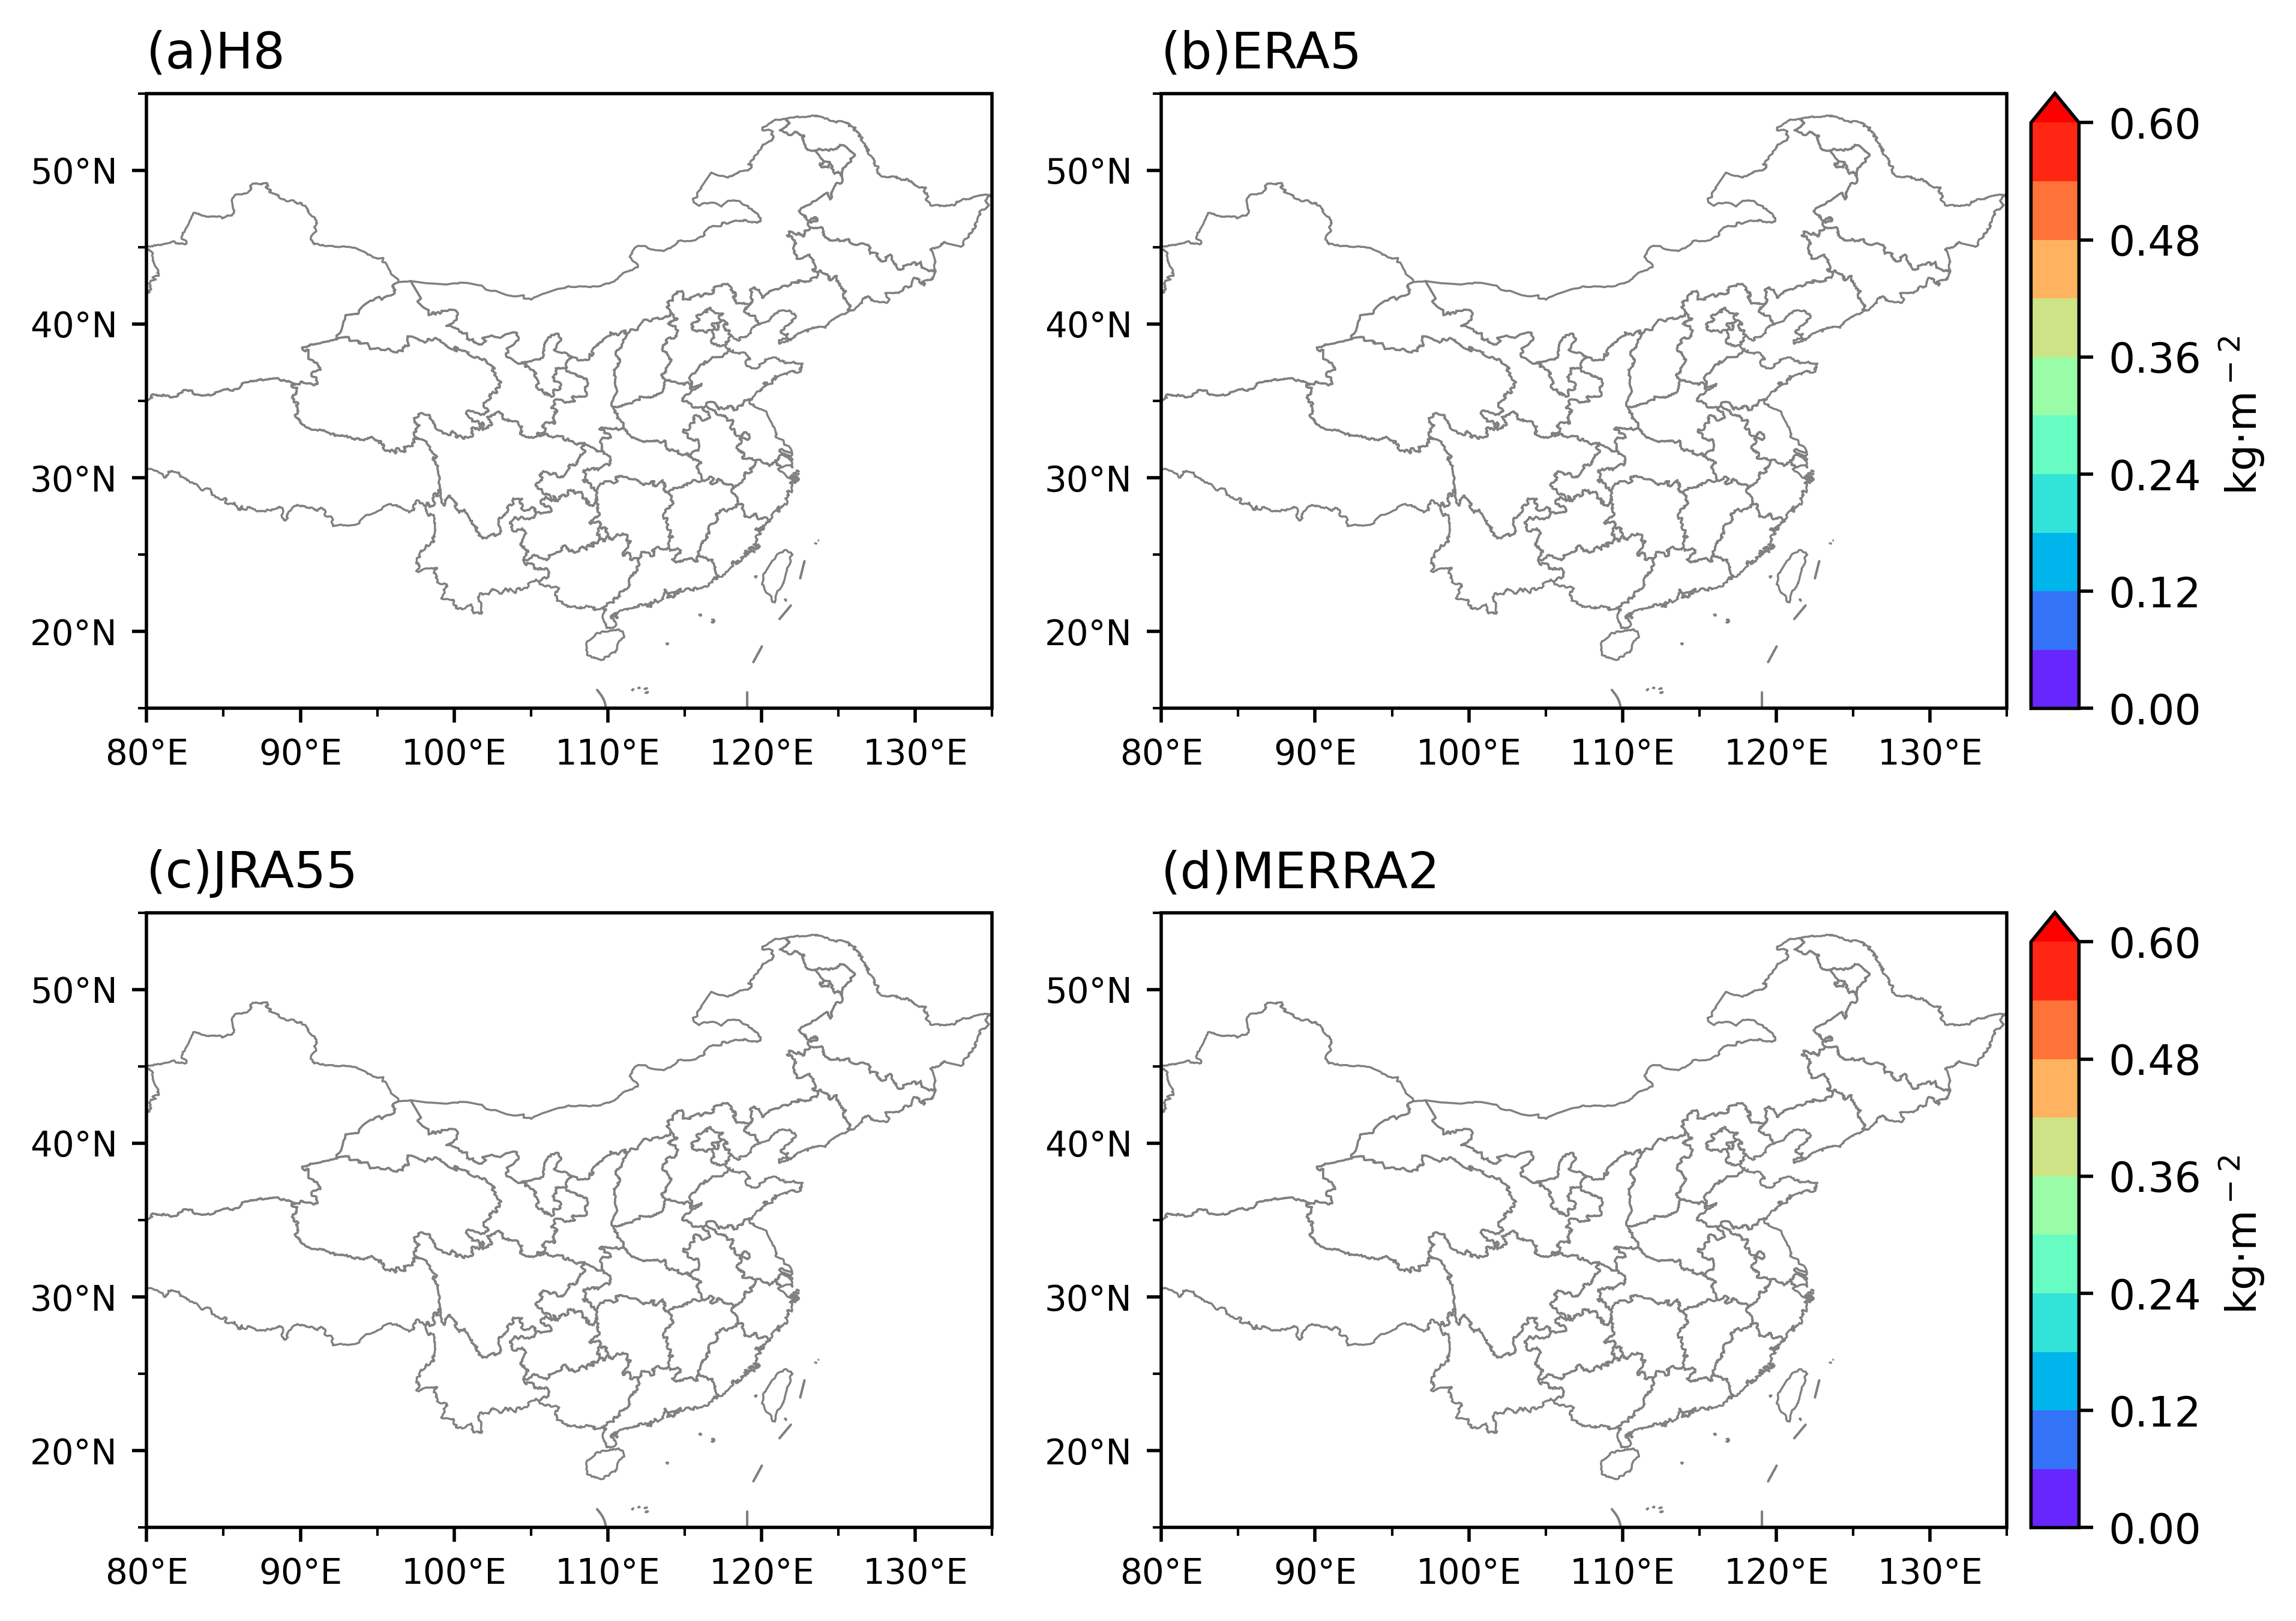

In [20]:
#绘制单时次的数据，检查是否有误
lwp_CHN_ori = H8_bar[0][100:1201, 0:1201]
ERA5_CHN_cw = ERA5_data[fileindex,0,:,:]
JRA55_CHN_cw = JRA55_data[fileindex,0,:,:]
MERRA2_CHN_cw = MERRA2_data[fileindex,0,:,:]
plt.close()
plot_pic(lwp_CHN_ori, ERA5_CHN_cw, JRA55_CHN_cw, MERRA2_CHN_cw)

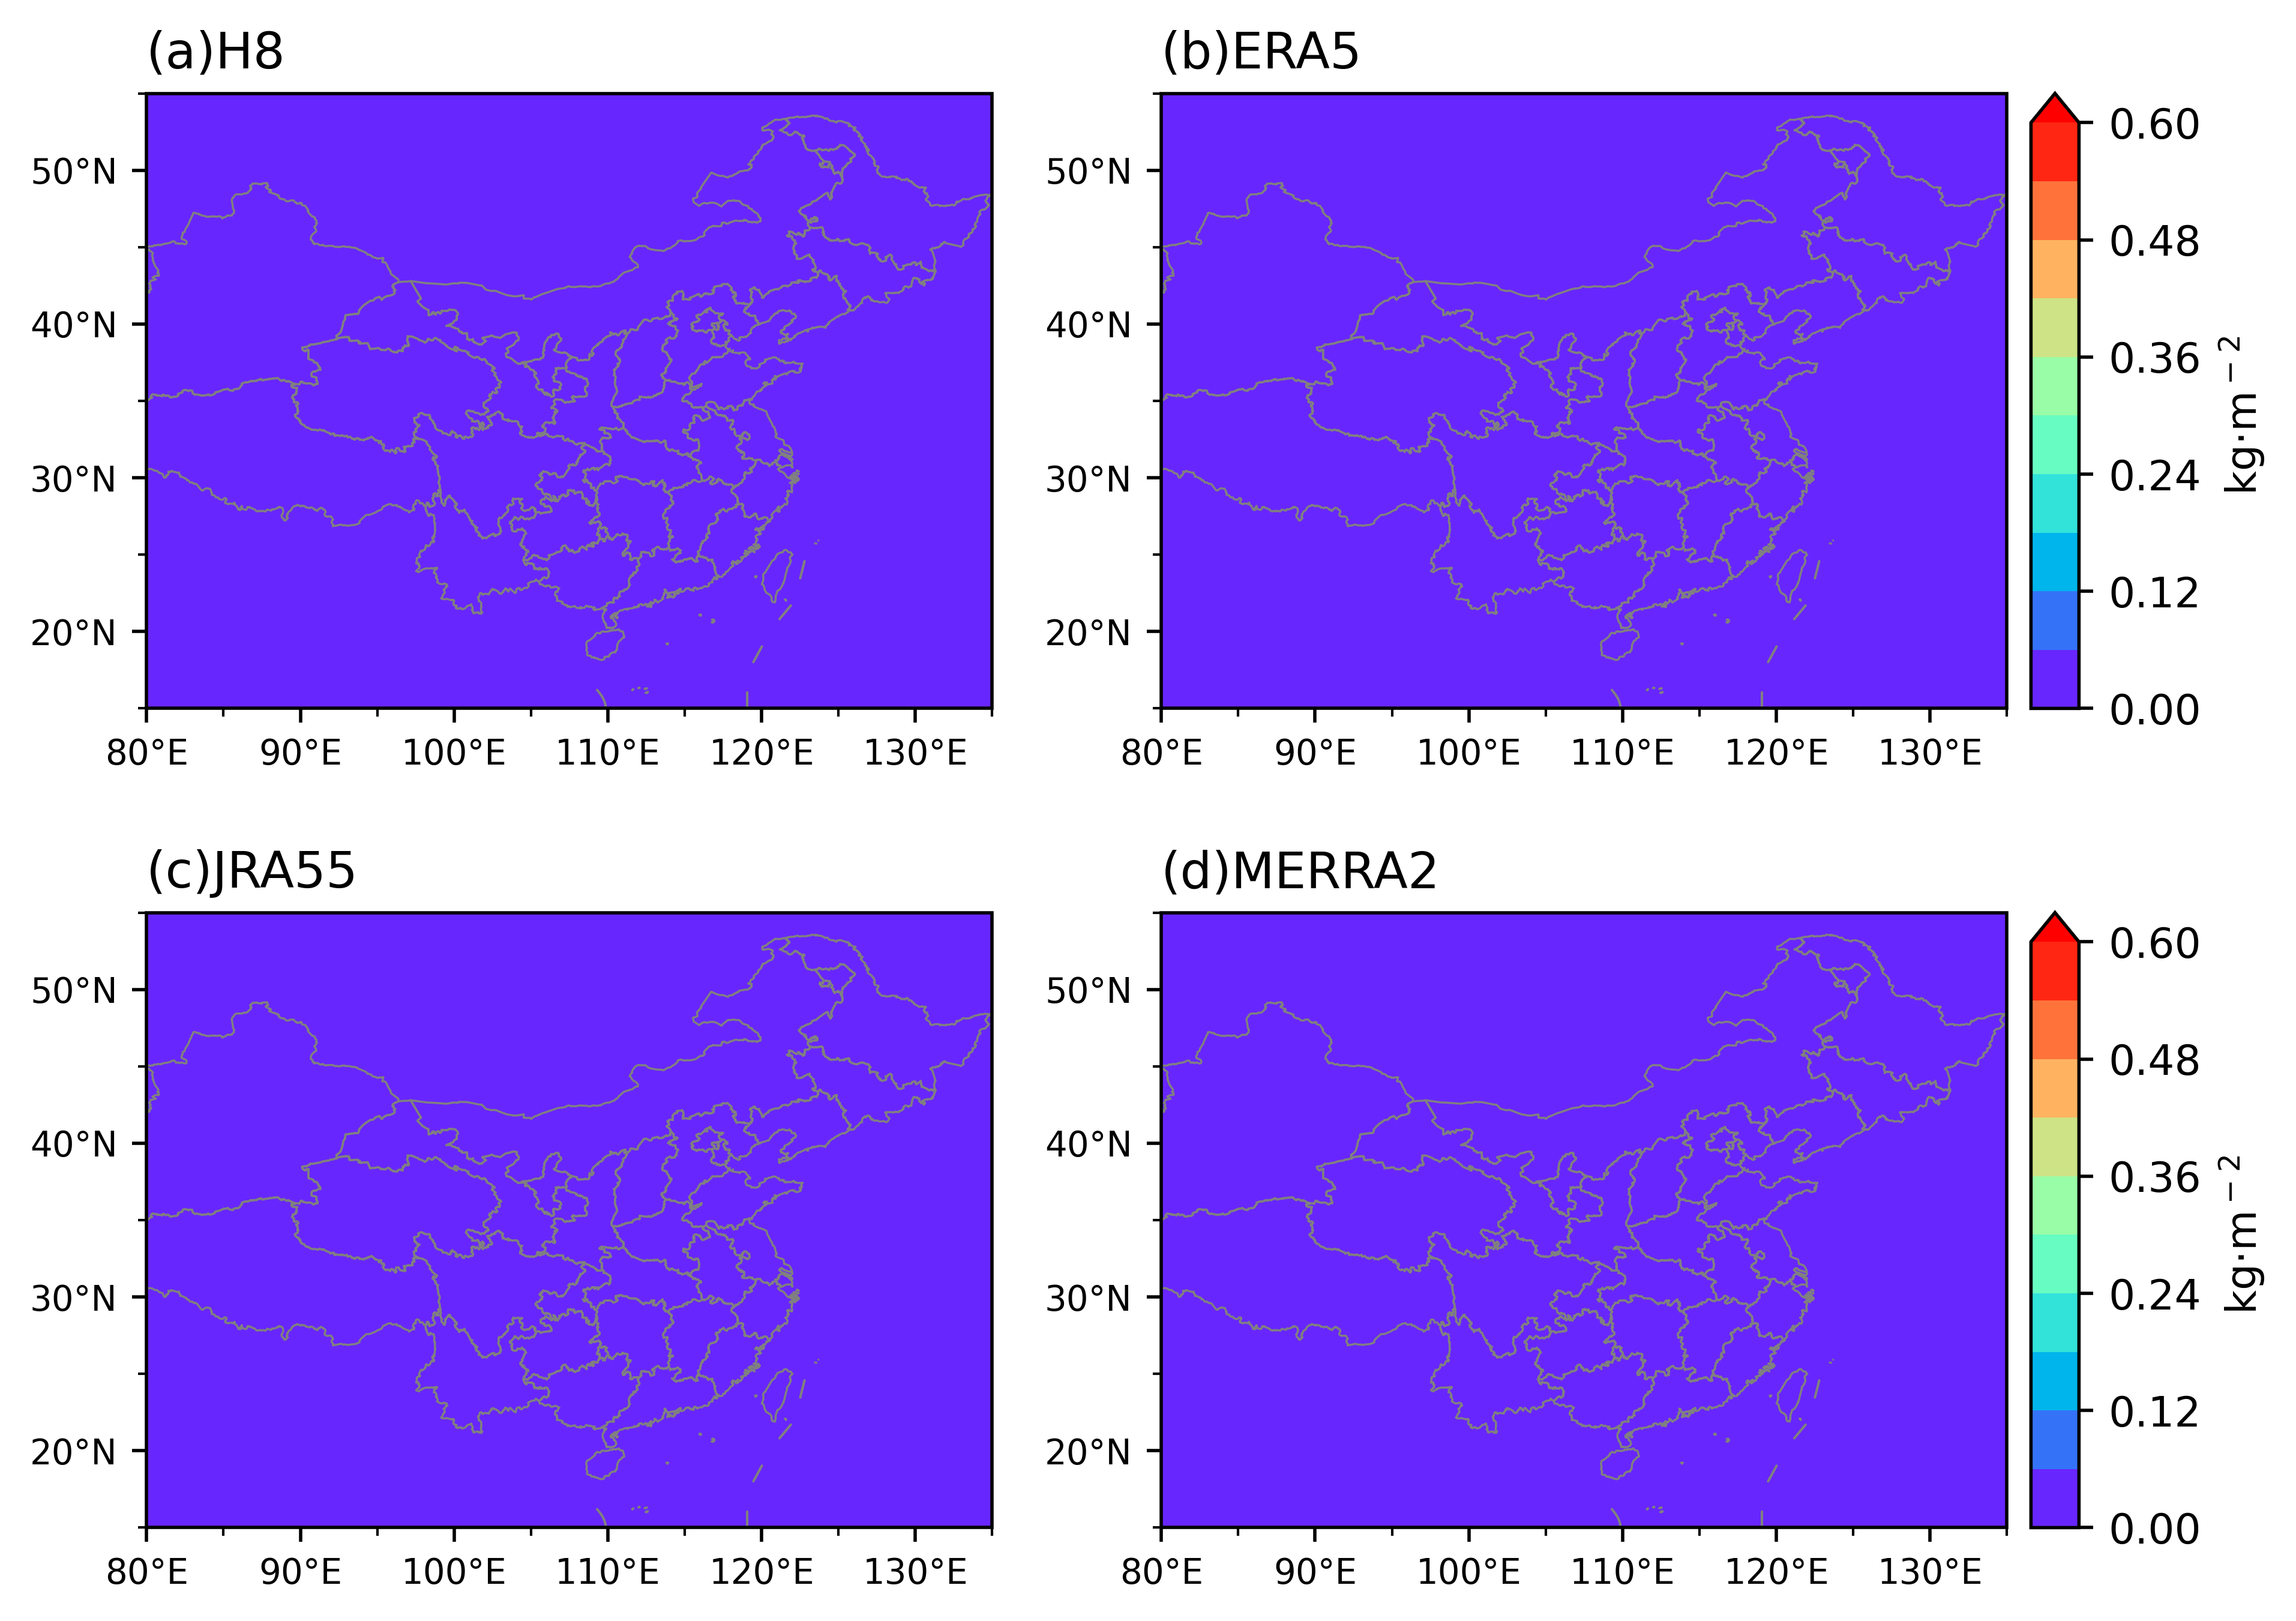

In [23]:
sc_CHN_ori = H8_bar[2][100:1201, 0:1201]
ERA5_CHN_sc = ERA5_data[fileindex,2,:,:]
JRA55_CHN_sc = JRA55_data[fileindex,2,:,:]
MERRA2_CHN_sc = MERRA2_data[fileindex,2,:,:]
plt.close()
plot_pic(sc_CHN_ori, ERA5_CHN_sc, JRA55_CHN_sc, MERRA2_CHN_sc)